# 309.2. Filter transformations

<div style="max-width:300px; float: left; margin-right: 1em">

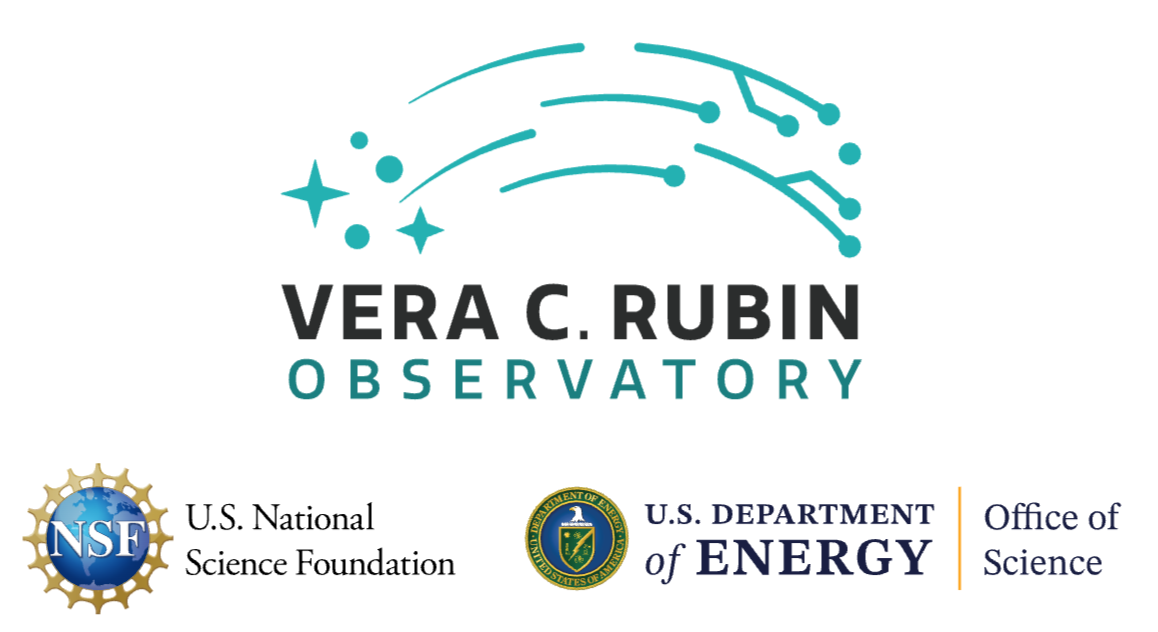

</div>

For the Rubin Science Platform at data.lsst.cloud.\
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a>\
Container Size: medium\
LSST Science Pipelines version: v29.2.0\
Last verified to run: 2026-02-10\
Repository: [github.com/lsst/tutorial-notebooks](https://github.com/lsst/tutorial-notebooks)\
DOI: [10.11578/rubin/dc.20250909.20](https://doi.org/10.11578/rubin/dc.20250909.20)

**Learning objective:** An overview of transformation relations to and from the LSSTComCam photometric system presented in Data Preview 1 and other popular photometric systems and how to apply these relations.

**LSST data products:** `Object`

**Packages:** `lsst.rsp`, `lsst.afw.display`

**Credit:**
Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

Being able to transform measurements between different photometric systems is essential for comparing results with not only contemporaneous and legacy data sets but also with theoretical models (e.g., stellar isochrones) derived using legacy photometric systems.

To this end, the Vera C. Rubin Project has generated transformation relations between the Data Preview 1 (DP1) $ugrizy$ system and other systems, like PanSTARRS1, Dark Energy Survey (DES), EUCLID, Gaia DR3, Johnson-Cousins, and others.  These transformation relations are provided in Rubin Technical Publication \#99 (<a href="https://rtn-099.lsst.io/">RTN-099</a>).  (For those interested, Jupyter notebooks used for calculating the transformation relations provided in RTN-099 can be found in <a href="https://github.com/lsst-sitcom/sciunit_photocalib/tree/main/notebooks/FilterTransforms">this github repository</a>.)  

Two methods for transforming between photometric systems are explored in <a href="https://rtn-099.lsst.io/">RTN-099</a>:  polynomial relations and lookup tables.  The guiding principle for which is to use is driven by the balance between simplicity and accuracy:  in general, simple first- or second-order polynomials are sufficient, but, for higher accuracy, one may choose the slightly more difficult-to-employ lookup-table method, instead.

Provided here is a tutorial of how to apply both methods of photometric transformation.  Examples are provided for converting from Rubin DP1 $i$-band photometry to the PanSTARRS1 DR2 and to the DES DR2 $i$ bands, and from Rubin DP1 $g$-band photometry to Gaia DR3 $RP$-band photometry.



**Related tutorials:** The 100-level tutorials demonstrate how to use the butler, the TAP service, and the Firefly image display. The 200-level tutorials introduce the types of image and catalog data.


### 1.1. Import packages

Import general python packages `math`, `numpy`, `pandas`, `scipy`, `astropy`, and `matplotlib`.
Import the `pyvo` module for accessing remote data.
From the `lsst` package, import the module for accessing the Table Access Protocol (TAP) service.


In [1]:
import math
import numpy as np
import pandas as pd
from scipy import interpolate
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import pyvo

from lsst.rsp import get_tap_service

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [9]:
service = get_tap_service("tap")
assert service is not None

Define the approximate central coordinates of the ECDFS field and a `radius` of 0.25 degrees about this center.

_Note: The radius is restricted to 0.25 degrees here, since the public PanSTARRS1 DR2 TAP service -- which is used later in this notebook -- is currently restricted to cone searches of no larger than 0.25 degrees._

In [3]:
ra_cen = 53.2
dec_cen = -28.1
radius = 0.25

Define parameters to use colorblind-friendly colors with `matplotlib`.

In [4]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Define a function for cross-matching between sky catalogs.

_(This could conceivably be replaced by using the LSDB package, but this function makes the method general enough to use for catalogs that are not yet in the LSDB set of surveys.)_

In [5]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Additional mask to ensure indices are valid
    valid_idx_mask = idx[mask] < len(df2)
    combined_mask = mask.copy()
    combined_mask[mask] = valid_idx_mask
    
    # Create a new dataframe with matches
    matches = df1[combined_mask].copy()
    matches['match_idx'] = idx[combined_mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[combined_mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        # This is a safer way to to this, avoid out-of-bound indices:
        matches[f'match_{col}'] = df2.iloc[idx[combined_mask]][col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~combined_mask]

    return matches, unmatched

## 2. Grab LSSTComCam ECDFS point source data from DP1



Define query to grab stars in ECDFS point source data from DP1.  To avoid potentially saturated stars and very faint stars, restrict the sample returned to those point sources with $r$-band magnitudes between 16.0 and 24.0.

In [10]:
query = """SELECT coord_ra, coord_dec, objectId,
           u_psfMag, g_psfMag, r_psfMag, i_psfMag, z_psfMag,
           u_psfMagErr, g_psfMagErr, r_psfMagErr, i_psfMagErr, z_psfMagErr,
           refExtendedness 
           FROM dp1.Object 
           WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', %f, %f, %f))=1
           AND refExtendedness=0
           AND r_psfMag BETWEEN 16.0 AND 24.0""" % (ra_cen, dec_cen, radius)

Submit asychronous query.

In [11]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is ERROR


DALQueryError: Query Error: Qserv request failed: operation failed due to: MySqlConnection::getMySql connection is not open.

Put results into a pandas dataframe table. 

In [8]:
df_dp1 = job.fetch_result().to_table().to_pandas()
print(f"Total number of visits: {len(df_dp1)}")

Total number of visits: 979


Display table. 

In [9]:
df_dp1

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,r_psfMagErr,i_psfMagErr,z_psfMagErr,refExtendedness
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,0.000190,0.000247,0.000319,0.0
1,53.448204,-28.037606,611254316728079756,25.531500,23.614901,22.276501,21.103300,20.583799,0.339714,0.008660,0.003279,0.002096,0.002466,0.0
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,0.000100,0.000092,0.000093,0.0
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,0.000082,0.000112,0.000124,0.0
4,53.414971,-28.053233,611254316728078899,26.046600,23.978100,22.803400,22.283100,22.035400,0.492280,0.011412,0.005248,0.005710,0.008755,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,53.364575,-27.988567,611255003922838370,NaN,23.570101,22.291000,21.682800,21.408001,NaN,0.007885,0.003125,0.003134,0.004931,0.0
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,0.000651,0.000451,0.000522,0.0
976,53.157799,-27.852838,611255759837080880,NaN,24.310301,22.947599,22.084101,21.698500,NaN,0.015467,0.005415,0.004247,0.006067,0.0
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,0.000186,0.000230,0.000305,0.0


Calculate color indices and generate a color-magnitude diagram (CMD) plot.

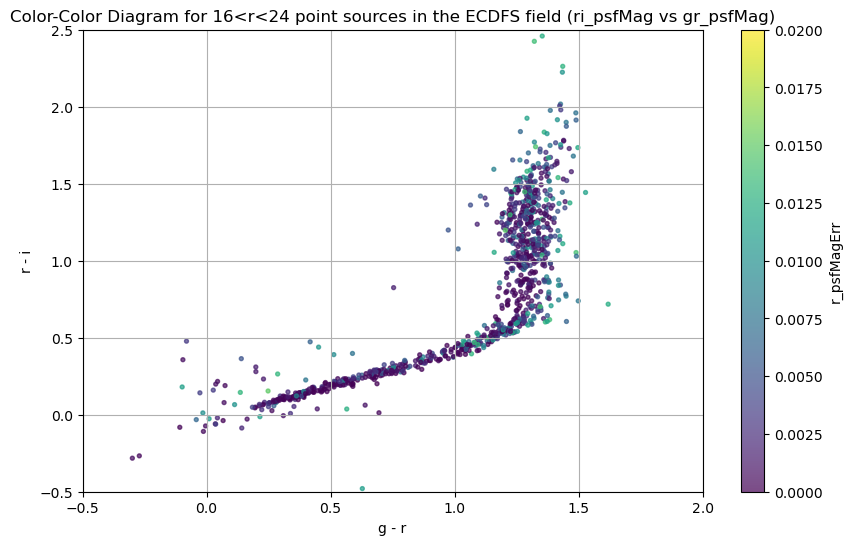

In [10]:
# Calculate g-r and r-i colors
df_dp1['gr_psfMag'] = df_dp1['g_psfMag'] - df_dp1['r_psfMag'] 
df_dp1['ri_psfMag'] = df_dp1['r_psfMag'] - df_dp1['i_psfMag'] 
df_dp1['gi_psfMag'] = df_dp1['g_psfMag'] - df_dp1['i_psfMag'] 

# Plotting r-i color index against the g-r color index, color-coded by r_psfMagErr
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_dp1['gr_psfMag'], 
    df_dp1['ri_psfMag'], 
    c=df_dp1['r_psfMagErr'],   # <-- color by error values
    cmap='viridis',            # choose a colormap (e.g. 'viridis', 'plasma', 'coolwarm')
    alpha=0.7, 
    s=8,
    vmin=0.00,   # lower bound of color scale
    vmax=0.02    # upper bound of color scale (values >0.02 saturate the color scale)
    )

plt.xlabel('g - r')
plt.ylabel('r - i')
plt.title('Color-Color Diagram for 16<r<24 point sources in the ECDFS field (ri_psfMag vs gr_psfMag)')
plt.gca().invert_yaxis()  # Magnitude scale is inverted
plt.grid(True)
plt.xlim(-0.5, 2.0)
plt.ylim(-0.5, 2.5)

# Add colorbar to show mapping of r_psfMagErr
cbar = plt.colorbar(sc)
cbar.set_label('r_psfMagErr')

plt.show()


## 3. First-order polynomial transformation:  LSSTComCam $i$ --> PanSTARRS1 DR2 $i$

As a simple first case, look at the polynomial transformation from DP1 $i$-band to PanSTARRS1 DR2 $i$-band.


### 3.1 Examine the transformation relation

Find the section in <a href="https://rtn-099.lsst.io/">RTN-099</a> that describes the polynomial transformation relation between the DP1 system and the PanSTARRS1 DR2 system.

Here is the line from RTN-099 that describes the transform from DP1 $i$-band to PanSTARRS1 DR2 $i$-band:


| Conversion | Transformation Equation | RMS | Applicable Color Range | QA Plot |
|:----------------|:----------|:-------|:-------|:------|
| $i_{ComCam} \to i_{ps1}$ | $i_{ps1} - i_{ComCam} = +0.014 (g-i)_{ComCam} - 0.016$ | 0.01 | $-2.2 < (g-i)_{ComCam} \leq 3.0$ | [link](_static/plots/qaPlot.ComCam_to_PS1DR2.fit.dmag_i_ps1-i_ComCam.gi_ComCam.norder1.qa1.png) |



Here are the quality assurance (QA) plots from <a href="https://rtn-099.lsst.io/">RTN-099</a> associated with the first-order polynomial fit of the DP1 $i$-band to PanSTARRS1 DR2 $i$-band: 

![Comparison of LSSTComCam DP1 and PanSTARRS1 DR2 i-band photometry](https://rtn-099.lsst.io/_downloads/46b297cc02e756ba30cc5844af0ed1ff/qaPlot.ComCam_to_PS1DR2.fit.dmag_i_ps1-i_ComCam.gi_ComCam.norder1.qa1.png)

*Figure 1: Comparison of LSSTComCam and PS1 DR2 i-band photometry.  (top left) The fit polynomial equation, the RMS of the fit, and the applicable color range.  (top right) The difference in the two magnitudes vs. color before any transformation.  (bottom left) 1d histogram of the residuals of the fit.  (bottom right)  residuals of the fit vs. color.*

### 3.2  Apply the transformation

Apply the the transformation to the LSSTComCam data in the ECDFS field.

In [11]:
# Calculate and apply the polynomial offset...

# Exclude stars outside the extreme color limits???

df_dp1['i_ps1_poly_offset'] = +0.014*df_dp1['gi_psfMag'] - 0.016
df_dp1['i_ps1_poly'] = df_dp1['i_psfMag'] + df_dp1['i_ps1_poly_offset']
display(df_dp1)


,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,r_psfMagErr,i_psfMagErr,z_psfMagErr,refExtendedness,gr_psfMag,ri_psfMag,gi_psfMag,i_ps1_poly_offset,i_ps1_poly
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,0.000190,0.000247,0.000319,0.0,0.584400,0.195700,0.780100,-0.005079,17.968620
1,53.448204,-28.037606,611254316728079756,25.531500,23.614901,22.276501,21.103300,20.583799,0.339714,0.008660,0.003279,0.002096,0.002466,0.0,1.338400,1.173201,2.511600,0.019162,21.122463
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,0.000100,0.000092,0.000093,0.0,1.289400,1.058001,2.347401,0.016864,15.796063
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,0.000082,0.000112,0.000124,0.0,0.392401,0.112600,0.505001,-0.008930,16.221069
4,53.414971,-28.053233,611254316728078899,26.046600,23.978100,22.803400,22.283100,22.035400,0.492280,0.011412,0.005248,0.005710,0.008755,0.0,1.174700,0.520300,1.695000,0.007730,22.290831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,53.364575,-27.988567,611255003922838370,NaN,23.570101,22.291000,21.682800,21.408001,NaN,0.007885,0.003125,0.003134,0.004931,0.0,1.279100,0.608200,1.887300,0.010422,21.693222
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,0.000651,0.000451,0.000522,0.0,1.296000,1.106300,2.402300,0.017632,19.304232
976,53.157799,-27.852838,611255759837080880,NaN,24.310301,22.947599,22.084101,21.698500,NaN,0.015467,0.005415,0.004247,0.006067,0.0,1.362701,0.863499,2.226200,0.015167,22.099268
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,0.000186,0.000230,0.000305,0.0,0.477600,0.202900,0.680500,-0.006473,18.038227


### 3.3  Test the transformation

Test the transformation by comparing the PS1 i-band magnitudes estimated from the DP1 data in ECDFS against the PS1 i-band magnitudes from the PanSTARRS1 DR2 data themselves in ECDFS.

### 3.3.1  Grab ECDFS data from PanSTARRS1 DR2

Query the PanSTARRS1 DR2 TAP service, using suitable constraints for point sources.  Since the PanSTARRS1 DR2 TAP service has a cone search maximum search radius of 0.25 deg, keep the search to that fixed radius.

In [12]:
ps1dr2_tap_url = 'https://mast.stsci.edu/vo-tap/api/v0.1/ps1dr2'
ps1dr2_tap = pyvo.dal.TAPService(ps1dr2_tap_url)

query = """
        SELECT  
            o.objName,
            o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,
            o.qualityFlag,
            o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
            o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
            o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
            o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanPSFMagNpt,
            o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanPSFMagNpt,
            o.rMeanKronMag, o.rMeanKronMagErr,
            o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
            o.gFlags, o.gQfPerfect,
            o.rFlags, o.rQfPerfect,
            o.iFlags, o.iQfPerfect,
            o.zFlags, o.zQfPerfect,
            o.yFlags, o.yQfPerfect,
            soa.primaryDetection, soa.bestDetection
        FROM dbo.MeanObjectView o
        LEFT JOIN StackObjectAttributes AS soa ON soa.objID = o.objID
        WHERE CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',%f,%f,0.25))=1
            AND o.nDetections > 5
            AND soa.primaryDetection>0
            AND o.gQfPerfect>0.85 and o.rQfPerfect>0.85 and o.iQfPerfect>0.85 and o.zQfPerfect>0.85
            AND (o.rmeanpsfmag - o.rmeankronmag < 0.05)
        """ % (ra_cen, dec_cen)

# Run the query
result = ps1dr2_tap.run_sync(query)
# Convert to pandas dataframe and append to list
df_ps1 = result.to_table().to_pandas()
display(df_ps1)


,objname,ramean,decmean,rameanerr,decmeanerr,qualityflag,gmeanpsfmag,gmeanpsfmagerr,gmeanpsfmagnpt,rmeanpsfmag,...,rflags,rqfperfect,iflags,iqfperfect,zflags,zqfperfect,yflags,yqfperfect,primarydetection,bestdetection
0,PSO J053.2053-28.1025,53.205258,-28.102504,0.000257,0.000254,60,16.249599,0.002916,8,15.444500,...,115000,0.999007,115000,0.999607,115000,0.999260,115000,0.999621,1,1
1,PSO J053.2136-28.1035,53.213591,-28.103538,0.006192,0.006192,52,21.716400,0.159966,2,21.013000,...,115000,0.999452,115000,0.998906,115000,0.998798,115000,0.999255,1,1
2,PSO J053.1857-28.0962,53.185732,-28.096155,0.007870,0.007870,52,21.532301,0.113475,4,20.758801,...,115000,0.999182,115000,0.999670,16892216,0.998925,115000,0.998171,1,1
3,PSO J053.2076-28.1115,53.207586,-28.111470,0.002046,0.002060,60,20.739201,0.033610,10,19.546400,...,115000,0.999495,115000,0.999721,115000,0.999418,115000,0.999100,1,1
4,PSO J053.2077-28.0874,53.207660,-28.087387,0.017049,0.017049,52,21.414101,0.062471,7,21.348700,...,115000,0.999683,115000,0.999160,115000,0.997787,16416,-999.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,PSO J053.4192-27.9430,53.419241,-27.942965,0.006237,0.006237,52,21.976101,0.049476,3,21.126301,...,115000,0.999819,115000,0.999663,115000,0.999677,115000,0.999210,1,1
557,PSO J053.4747-28.1591,53.474655,-28.159108,0.000172,0.000166,60,15.261600,0.001353,8,14.883000,...,115000,0.999382,115000,0.999436,115000,0.999246,115000,0.998999,1,1
558,PSO J053.2714-27.8584,53.271389,-27.858392,0.000127,0.000126,60,14.308200,0.001120,8,13.932300,...,115000,0.999183,115000,0.999647,115000,0.999652,115000,0.999639,1,1
559,PSO J053.2313-27.8518,53.231289,-27.851834,0.000243,0.000241,60,16.986099,0.001890,9,15.924100,...,115000,0.999298,115000,0.999348,115000,0.999691,115000,0.999732,1,1


### 3.3.2  Match the ECDFS data from LSSTComCam with the ECDFS data from PanSTARRS1 DR2

Use the `cross_match_catalogs` function to match the the two catalogs.

In [13]:
matches_dp1_ps1, unmatched_dp1_ps1 = cross_match_catalogs(df_dp1, df_ps1, 'coord_ra', 'coord_dec', 'ramean', 'decmean')
display(matches_dp1_ps1)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,match_rflags,match_rqfperfect,match_iflags,match_iqfperfect,match_zflags,match_zqfperfect,match_yflags,match_yqfperfect,match_primarydetection,match_bestdetection
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,...,115000,0.999421,115000,0.999803,115000,0.999685,115000,0.998985,1,1
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,115000,0.998929,115000,0.999422,115000,0.999637,115000,0.998971,1,1
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,115000,0.999408,115000,0.999633,115000,0.999694,115000,0.999660,1,1
8,53.445303,-28.021608,611254316728080864,20.501801,19.682800,19.399900,19.315201,19.301399,0.004243,0.000417,...,115000,0.999809,115000,0.999657,115000,0.999673,115000,0.999638,1,1
10,53.434026,-27.987798,611255003922837626,24.339100,21.867201,20.489100,19.273600,18.743799,0.121975,0.001883,...,115000,0.999764,115000,0.999650,115000,0.999738,115000,0.999557,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,53.308397,-28.003264,611255003922837095,21.004200,18.684999,17.624800,17.171301,16.965500,0.005811,0.000221,...,115000,0.999032,115000,0.999603,115000,0.999267,115000,0.999643,1,1
972,53.374402,-28.000406,611255003922837961,24.340900,21.671101,20.410999,19.246099,18.739000,0.115094,0.001557,...,115000,0.999715,115000,0.999850,115000,0.998982,115000,0.999155,1,1
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,...,115000,0.998865,115000,0.999814,115000,0.999316,115000,0.999555,1,1
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,...,115000,0.999720,115000,0.999564,115000,0.999186,115000,0.999574,1,1


### 3.3.3  Compare the LSSTComCam-estimated PS1 i-band magnitudes with the PanSTARRS1 DR2 i-band magnitudes

Calculate both the differences between the DP1 $i$-band magnitude and the PanSTARRS1 DR2 $i$-band magnitude ("before transformation") and the differences between DP1-estimated PS1 $i$-band magnitude and the PanSTARRS1 DR2 $i$-band magnitude ("after transformation"):

In [14]:
matches_dp1_ps1['dmag_i_cc_ps1'] = matches_dp1_ps1['i_psfMag'] - matches_dp1_ps1['match_imeanpsfmag']
matches_dp1_ps1['dmag_i_ps1_poly'] = matches_dp1_ps1['i_ps1_poly'] - matches_dp1_ps1['match_imeanpsfmag']

Plot the histogram of the $\Delta$mags (both before transformation and post transformation).

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $i$-band and PanSTARRS1 DR2 $i$-band')

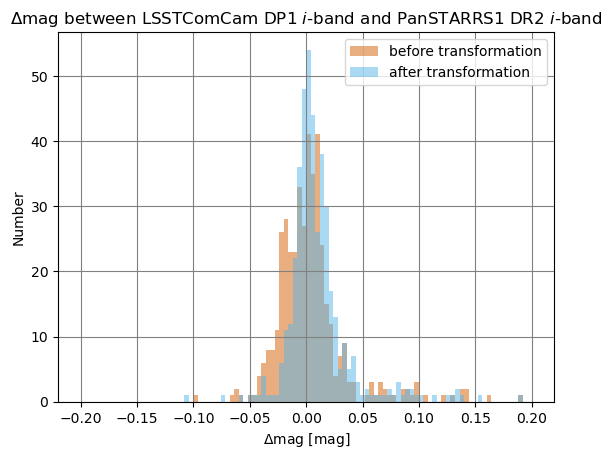

In [15]:
dmag_orig = matches_dp1_ps1.loc[:,'dmag_i_cc_ps1']
dmag_new  = matches_dp1_ps1.loc[:,'dmag_i_ps1_poly']

dmag_min = -0.2
dmag_max = 0.2

if len(dmag_new) < 100:
    plt.hist(dmag_orig, bins=10, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=10, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
else:
    plt.hist(dmag_orig, bins=100, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=100, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
plt.xlabel('$\\Delta$mag [mag]')
plt.ylabel('Number')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $i$-band and PanSTARRS1 DR2 $i$-band")

Create a scatter plot of the $\Delta$mags (both before transformation and post transformation) vs. color.  Note that LSSTCamCom DP1 $i$-band and PanSTARRS1 DR2 $i$-band are fairly similar; so the transformation is relatively small.

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $i$-band and PanSTARRS1 DR2 $i$-band vs. color')

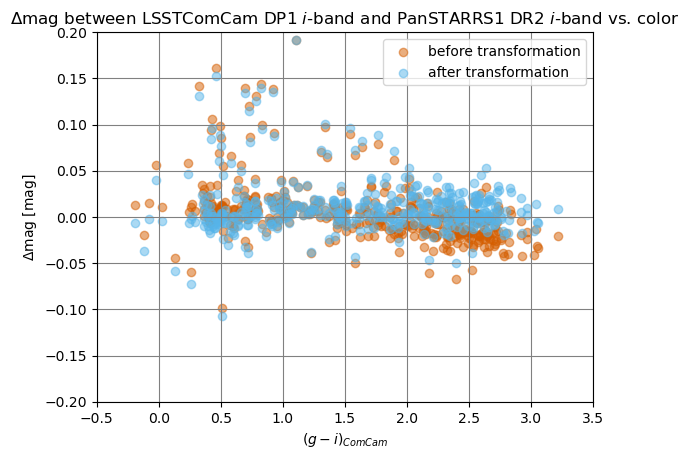

In [16]:
color = matches_dp1_ps1.loc[:,'gi_psfMag']

dmag_min = -0.2
dmag_max = 0.2
color_min = -0.5
color_max = 3.5

plt.scatter(color, dmag_orig, color=colors[2], alpha=0.50, label='before transformation')
plt.scatter(color, dmag_new, color=colors[5], alpha=0.50, label='after transformation')
plt.axis([color_min, color_max, dmag_min, dmag_max])
plt.xlabel('$(g-i)_{ComCam}$')
plt.ylabel('$\\Delta$mag [mag]')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $i$-band and PanSTARRS1 DR2 $i$-band vs. color")

## 4. Piecewise 1st-order polynomial transformation:  LSSTComCam $i$ --> DES DR2 $i$

Now look at the polynomial transformation from DP1 $i$-band to DES DR2 $i$-band.  This is a little more complicated than the previous example, as there is a break in the relation; so this polynomial had to be fit piece-wise, with a break at $(g-i)_{ComCam} = 1.8$.


### 4.1 Examine the transformation relation

Find the section in <a href="https://rtn-099.lsst.io/">RTN-099</a> that describes the polynomial transformation relation between the DP1 system and the DES DR2 system.

Here are the lines from RTN-099 that describes the transform from DP1 $i$-band to DES DR2 $i$-band:

| Conversion | Transformation Equation | RMS | Applicable Color Range | QA Plot |
|----------------|----------|-------|-------|------|
| $i_{ComCam} \to i_{des}$ | $i_{des} - i_{ComCam} = -0.043 (g-i)_{ComCam} +0.017$ | 0.006 | $-0.6 < (g-i)_{ComCam} \leq 1.8$ | [link](_static/plots/qaPlot.ComCam_to_DESDR2_ECDFS.fit.dmag_i_des-i_ComCam.gi_ComCam.norder1.qa1.png) |
| $i_{ComCam} \to i_{des}$ | $i_{des} - i_{ComCam} = -0.122 (g-i)_{ComCam} +0.157$ | 0.009 | $1.8 < (g-i)_{ComCam} \leq 3.7$  | [link](_static/plots/qaPlot.ComCam_to_DESDR2_ECDFS.fit.dmag_i_des-i_ComCam.gi_ComCam.norder1.qa1.png) |

Here are the quality assurance (QA) plots from <a href="https://rtn-099.lsst.io/">RTN-099</a> associated with the first-order piece-wise polynomial fit of the DP1 $i$-band to DES DR2 $i$-band: 

![Alt text](https://rtn-099.lsst.io/_downloads/0d5bd60339db84127abb8bd0f7b096e0/qaPlot.ComCam_to_DESDR2_ECDFS.fit.dmag_i_des-i_ComCam.gi_ComCam.norder1.qa1.png)

*Figure 2: Comparison of LSSTComCam photometry with DES DR2 photometry.  (top left) The fit polynomial equation, the RMS of the fit, and the applicable color range.  (top right) The difference in the two magnitudes vs. color before any transformation.  (bottom left) 1d histogram of the residuals of the fit.  (bottom right)  residuals of the fit vs. color.*

### 4.2  Apply the transformation

Apply the the transformation to the LSSTComCam data in the ECDFS field.

In [17]:
# Calculate and apply the piece-wise polynomial offset...

# Define conditions for the two ranges
condlist = [
    (df_dp1['gi_psfMag'] > -0.6) & (df_dp1['gi_psfMag'] <= 1.8),
    (df_dp1['gi_psfMag'] > 1.8) & (df_dp1['gi_psfMag'] <= 3.7)
]

# Define corresponding offset formulas
choicelist = [
    -0.043 * df_dp1['gi_psfMag'] + 0.017,
    -0.122 * df_dp1['gi_psfMag'] + 0.157
]

# Apply piece-wise offsets
df_dp1['i_des_poly_offset'] = np.select(condlist, choicelist, default=np.nan)

# Compute DES i magnitudes
df_dp1['i_des_poly'] = df_dp1['i_psfMag'] + df_dp1['i_des_poly_offset']

display(df_dp1)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,i_psfMagErr,z_psfMagErr,refExtendedness,gr_psfMag,ri_psfMag,gi_psfMag,i_ps1_poly_offset,i_ps1_poly,i_des_poly_offset,i_des_poly
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,...,0.000247,0.000319,0.0,0.584400,0.195700,0.780100,-0.005079,17.968620,-0.016544,17.957155
1,53.448204,-28.037606,611254316728079756,25.531500,23.614901,22.276501,21.103300,20.583799,0.339714,0.008660,...,0.002096,0.002466,0.0,1.338400,1.173201,2.511600,0.019162,21.122463,-0.149415,20.953884
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,0.000092,0.000093,0.0,1.289400,1.058001,2.347401,0.016864,15.796063,-0.129383,15.649817
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,0.000112,0.000124,0.0,0.392401,0.112600,0.505001,-0.008930,16.221069,-0.004715,16.225285
4,53.414971,-28.053233,611254316728078899,26.046600,23.978100,22.803400,22.283100,22.035400,0.492280,0.011412,...,0.005710,0.008755,0.0,1.174700,0.520300,1.695000,0.007730,22.290831,-0.055885,22.227215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,53.364575,-27.988567,611255003922838370,NaN,23.570101,22.291000,21.682800,21.408001,NaN,0.007885,...,0.003134,0.004931,0.0,1.279100,0.608200,1.887300,0.010422,21.693222,-0.073251,21.609550
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,...,0.000451,0.000522,0.0,1.296000,1.106300,2.402300,0.017632,19.304232,-0.136081,19.150520
976,53.157799,-27.852838,611255759837080880,NaN,24.310301,22.947599,22.084101,21.698500,NaN,0.015467,...,0.004247,0.006067,0.0,1.362701,0.863499,2.226200,0.015167,22.099268,-0.114596,21.969503
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,...,0.000230,0.000305,0.0,0.477600,0.202900,0.680500,-0.006473,18.038227,-0.012262,18.032438


### 4.3  Test the transformation

Test the transformation by comparing the DES i-band magnitudes estimated from the DP1 data in ECDFS against the DES i-band magnitudes from the DES DR2 data themselves in ECDFS.

#### 4.3.1  Grab ECDFS data from DES DR2

Query the NOIRLab Astro Data Lab TAP service for the DES DR2 data, using suitable constraints for point sources.  Note that ADQL cone search does not seem to work for DES DR2; so ranges in ra and dec are used instead.

In [18]:
tap_service = pyvo.dal.TAPService("https://datalab.noirlab.edu/tap")


ra_min = ra_cen - radius/math.cos(math.radians(dec_cen))
ra_max = ra_cen + radius/math.cos(math.radians(dec_cen))
dec_min = dec_cen - radius
dec_max = dec_cen + radius

query = """
        SELECT ra, dec,  
               WAVG_MAG_PSF_G, WAVG_MAG_PSF_R, WAVG_MAG_PSF_I, WAVG_MAG_PSF_Z, WAVG_MAG_PSF_Y, 
               WAVG_MAGERR_PSF_G, WAVG_MAGERR_PSF_R, WAVG_MAGERR_PSF_I, WAVG_MAGERR_PSF_Z, WAVG_MAGERR_PSF_Y 
        FROM des_dr2.main
        WHERE (ra BETWEEN %f AND %f) AND (dec BETWEEN %f AND %f) AND
              (WAVG_MAGERR_PSF_R BETWEEN 0.00 AND 0.05) AND (WAVG_MAG_PSF_R < 24.0) AND 
              (EXTENDED_CLASS_WAVG = 0) AND 
              (FLAGS_G < 4 AND FLAGS_R < 4 AND FLAGS_I < 4)
        """ % (ra_min, ra_max, dec_min, dec_max)

results = tap_service.search(query)

# Convert to Astropy Table or Pandas DataFrame
table = results.to_table()
df_desdr2 = results.to_table().to_pandas()

display(df_desdr2)

,ra,dec,wavg_mag_psf_g,wavg_mag_psf_r,wavg_mag_psf_i,wavg_mag_psf_z,wavg_mag_psf_y,wavg_magerr_psf_g,wavg_magerr_psf_r,wavg_magerr_psf_i,wavg_magerr_psf_z,wavg_magerr_psf_y
0,52.918581,-28.346890,23.662474,23.150375,22.574963,22.278912,-99.000000,0.056319,0.040266,0.040061,0.053409,-99.000000
1,52.932437,-28.334583,22.521202,22.047487,21.908354,21.813982,21.334345,0.017677,0.013657,0.019619,0.029983,0.157573
2,52.956875,-28.349331,22.528536,21.059959,19.907223,19.433523,19.290817,0.019434,0.006651,0.003880,0.004008,0.018801
3,52.948132,-28.334659,-99.000000,23.387871,22.696175,22.455545,-99.000000,-99.000000,0.047060,0.040415,0.079611,-99.000000
4,52.918433,-28.304944,20.607925,19.725561,19.446699,19.295755,19.241159,0.004672,0.002641,0.002912,0.003923,0.013231
...,...,...,...,...,...,...,...,...,...,...,...,...
1142,53.453876,-27.865038,21.130634,20.031488,19.591478,19.360748,19.312788,0.006259,0.003236,0.002987,0.004197,0.013926
1143,53.453848,-27.859537,24.150980,22.975946,22.401678,22.123264,21.751177,0.160851,0.034488,0.034341,0.048219,0.194931
1144,53.454881,-27.857921,20.065844,19.783876,19.720797,19.689035,19.755556,0.002812,0.002433,0.003290,0.004985,0.019664
1145,53.459644,-27.855465,23.426256,22.152607,21.394825,21.075127,20.885798,0.045613,0.017077,0.014267,0.017413,0.056321


#### 4.3.2  Match the ECDFS data from LSSTComCam with the ECDFS data from DES DR2

Use the `cross_match_catalogs` function to match the the two catalogs.

In [19]:
matches_dp1_desdr2, unmatched_dp1_desdr2 = cross_match_catalogs(df_dp1, df_desdr2, 'coord_ra', 'coord_dec', 'ra', 'dec')
display(matches_dp1_desdr2)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,match_wavg_mag_psf_g,match_wavg_mag_psf_r,match_wavg_mag_psf_i,match_wavg_mag_psf_z,match_wavg_mag_psf_y,match_wavg_magerr_psf_g,match_wavg_magerr_psf_r,match_wavg_magerr_psf_i,match_wavg_magerr_psf_z,match_wavg_magerr_psf_y
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,...,18.757198,18.132021,17.955061,17.871950,17.864985,0.001315,0.000918,0.001098,0.001293,0.004692
1,53.448204,-28.037606,611254316728079756,25.531500,23.614901,22.276501,21.103300,20.583799,0.339714,0.008660,...,23.596159,22.130562,20.930836,20.441872,20.346460,0.041634,0.013359,0.007497,0.008251,0.030232
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,18.138571,16.693180,15.634200,15.190386,15.081191,0.000810,0.000347,0.000256,0.000258,0.000612
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,16.736082,16.319183,16.219542,16.191252,16.213533,0.000377,0.000299,0.000299,0.000352,0.001181
4,53.414971,-28.053233,611254316728078899,26.046600,23.978100,22.803400,22.283100,22.035400,0.492280,0.011412,...,23.868212,22.723917,22.255327,21.896471,-99.000000,0.074055,0.026382,0.027839,0.034908,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,53.364575,-27.988567,611255003922838370,NaN,23.570101,22.291000,21.682800,21.408001,NaN,0.007885,...,23.524759,22.190811,21.608541,21.318264,21.184011,0.044891,0.015714,0.014861,0.020969,0.092529
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,...,21.662987,20.235079,19.142170,18.679693,18.560568,0.008590,0.003215,0.001875,0.001977,0.006649
976,53.157799,-27.852838,611255759837080880,NaN,24.310301,22.947599,22.084101,21.698500,NaN,0.015467,...,24.179741,22.876030,21.948000,21.547461,21.351749,0.116018,0.028799,0.020319,0.026056,0.099965
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,...,18.727566,18.213245,18.020567,17.932455,17.931597,0.001458,0.001082,0.000996,0.001300,0.004991


#### 4.3.3  Compare the LSSTComCam-estimated PS1 i-band magnitudes with the DES DR2 i-band magnitudes

Calculate both the differences between the DP1 $i$-band magnitude and the DES DR2 $i$-band magnitude ("before transformation") and the differences between DP1-estimated DES $i$-band magnitude and the DES DR2 $i$-band magnitude ("after transformation"):

In [20]:
matches_dp1_desdr2['dmag_i_cc_des'] = matches_dp1_desdr2['i_psfMag'] - matches_dp1_desdr2['match_wavg_mag_psf_i']
matches_dp1_desdr2['dmag_i_des_poly'] = matches_dp1_desdr2['i_des_poly'] - matches_dp1_desdr2['match_wavg_mag_psf_i']

Plot the histogram of the $\Delta$mags (both before transformation and post transformation).

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $i$-band and DES DR2 $i$-band')

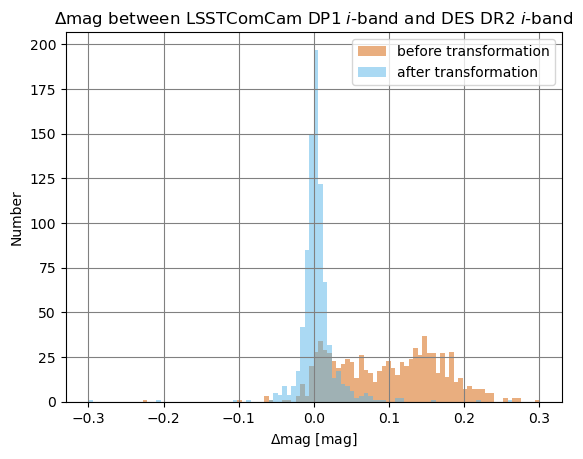

In [21]:
dmag_orig = matches_dp1_desdr2.loc[:,'dmag_i_cc_des']
dmag_new  = matches_dp1_desdr2.loc[:,'dmag_i_des_poly']

dmag_min = -0.3
dmag_max = 0.3

if len(dmag_new) < 100:
    plt.hist(dmag_orig, bins=10, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=10, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
else:
    plt.hist(dmag_orig, bins=100, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=100, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
plt.xlabel('$\\Delta$mag [mag]')
plt.ylabel('Number')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $i$-band and DES DR2 $i$-band")

Create a scatter plot of the $\Delta$mags (both before transformation and post transformation) vs. color.  Note that the DES DR2 $i$-band differs more from the LSSTCamCom DP1 $i$-band than does the PanSTARRS1 DR2 $i$-band; so the transformation is larger than in the previous example.

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $i$-band and DES DR2 $i$-band vs. color')

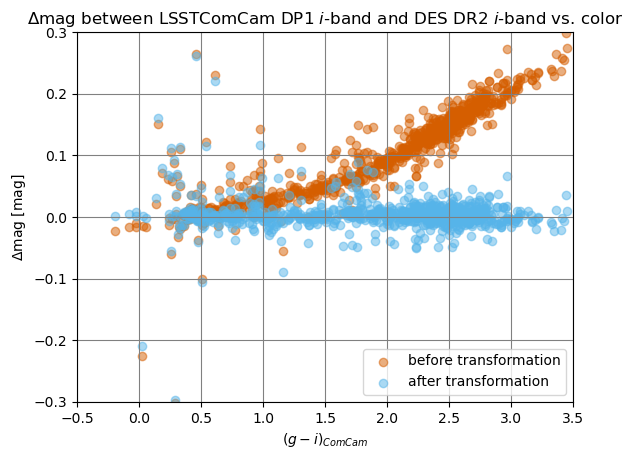

In [22]:
color = matches_dp1_desdr2.loc[:,'gi_psfMag']

dmag_min = -0.3
dmag_max = 0.3
color_min = -0.5
color_max = 3.5

plt.scatter(color, dmag_orig, color=colors[2], alpha=0.50, label='before transformation')
plt.scatter(color, dmag_new, color=colors[5], alpha=0.50, label='after transformation')
plt.axis([color_min, color_max, dmag_min, dmag_max])
plt.xlabel('$(g-i)_{ComCam}$')
plt.ylabel('$\\Delta$mag [mag]')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $i$-band and DES DR2 $i$-band vs. color")

## 5. Second-order polynomial transformation:  LSSTComCam $g$ --> Gaia DR3 $BP_{gaia}$

Next, look at the polynomial transformation from DP1 $g$-band to Gaia DR3 $BP$-band.  Here, a first-order polynomial fit is insufficient; so a second-order polynomial fit is employed.  One could consider even higher terms to achieve an even more accurate relation, but that is left to the lookup table transformation method described in the next section.

### 5.1 Examine the transformation relation

Find the section in <a href="https://rtn-099.lsst.io/">RTN-099</a> that describes the polynomial transformation relation between the DP1 system and the Gaia DR3 system.

Here are the lines from RTN-099 that describes the transform from DP1 $g$-band to Gaia DR3 $BP$-band:

| Conversion | Transformation Equation | RMS | Applicable Color Range | QA Plot |
|----------------|----------|-------|-------|------|
| $g_{ComCam} \to BP_{gaia}$ | $BP_{gaia} - g_{ComCam} = +0.081 (g-i)_{ComCam}^2 -0.449 (g-i)_{ComCam} +0.162$ | 0.027 | $-0.7 < (g-i)_{ComCam} \leq 3.0$ | [link](_static/plots/qaPlot.ComCam_to_GaiaDR3.fit.dmag_BP_gaia-g_ComCam.gi_ComCam.norder2.qa1.png) |


Here are the quality assurance (QA) plots from <a href="https://rtn-099.lsst.io/">RTN-099</a> associated with the second-order polynomial fit of the DP1 $g$-band to Gaia DR3 $RP$-band.  Note from the bottom-right plot that a third-order term might benefit the fit, but staying with the simpler second-order polynomial still achieves a 0.027 mag RMS in the fit.  For more accuracy, using the lookup table method (described in the next section) is recommended.

![Comparison of LSSTComCam DP1 g-band and Gaia DR3 BP-band photometry](https://rtn-099.lsst.io/_downloads/2317085f1bda0f2ac1827aa071c877be/qaPlot.ComCam_to_GaiaDR3.fit.dmag_BP_gaia-g_ComCam.gi_ComCam.norder2.qa1.png)

*Figure 3: Comparison of LSSTComCam g-band and Gaia DR3 BP-band photometry.  (top left) The fit polynomial equation, the RMS of the fit, and the applicable color range.  (top right) The difference in the two magnitudes vs. color before any transformation.  (bottom left) 1d histogram of the residuals of the fit.  (bottom right)  residuals of the fit vs. color.*

### 5.2  Apply the transformation

Apply the the transformation to the LSSTComCam data in the ECDFS field.

In [23]:
# Calculate and apply the polynomial offset...

# Exclude stars outside the extreme color limits???
df_dp1['BP_gaia_poly_offset'] = 0.081*np.pow(df_dp1['gi_psfMag'], 2.) - 0.449*df_dp1['gi_psfMag'] + 0.162
df_dp1['BP_gaia_poly'] = df_dp1['g_psfMag'] + df_dp1['BP_gaia_poly_offset']


### 5.3  Test the transformation

Test the transformation by comparing the Gaia DR3 $RP$-band magnitudes estimated from the DP1 data in ECDFS against the Gaia DR3 $RP$-band magnitudes from the Gaia DR3 data themselves in ECDFS.

#### 5.3.1  Grab ECDFS data from Gaia DR3

Query the Gaia DR3 TAP service, using suitable constraints for a clean sample.  

In [24]:
# Gaia DR3 TAP service
gaia_tap_url = 'https://gaia.aip.de/tap'
gaia_tap = pyvo.dal.TAPService(gaia_tap_url)

query = """
        SELECT 
            source_id, ra, dec, parallax, parallax_error,
            pmra, pmra_error, pmdec, pmdec_error,
            phot_g_mean_mag, 1.086/phot_g_mean_flux_over_error as phot_g_mean_mag_error, 
            phot_bp_mean_mag, 1.086/phot_bp_mean_flux_over_error as phot_bp_mean_mag_error, 
            phot_rp_mean_mag, 1.086/phot_rp_mean_flux_over_error as phot_rp_mean_mag_error,
            bp_rp
            FROM gaiadr3.gaia_source_lite
        WHERE 
            CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',%f,%f,%f))=1  
        AND parallax_over_error > 5 
        AND ruwe < 1.4  
        AND phot_g_mean_flux_over_error > 5  
        AND phot_rp_mean_flux_over_error > 5
        AND phot_bp_mean_flux_over_error > 5
        """ % (ra_cen, dec_cen, radius)

result = gaia_tap.run_sync(query)
df_gaiadr3 = result.to_table().to_pandas()

display(df_gaiadr3)


,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_mag,phot_rp_mean_mag_error,bp_rp
0,5057485279947122432,53.162925,-28.022007,1.770257,0.217018,3.083287,0.150263,-11.282898,0.215301,19.064352,0.001515,20.569189,0.055866,17.848970,0.010626,2.720219
1,5057485245588751744,53.178889,-28.021119,0.624164,0.023926,3.459924,0.016277,1.948652,0.022619,15.042624,0.000195,15.358116,0.001079,14.559050,0.000799,0.799067
2,5057485241292385408,53.186821,-28.022815,2.082418,0.199197,43.586944,0.134744,-21.106540,0.193789,18.900848,0.001319,20.290592,0.052763,17.728310,0.009864,2.562283
3,5057482393730465408,53.212412,-28.015258,0.508584,0.027519,5.088112,0.018480,-0.231467,0.026243,15.316686,0.000212,15.633938,0.001133,14.828444,0.000805,0.805493
4,5057482256291513984,53.190356,-28.036035,1.577806,0.062845,4.322827,0.044401,9.516738,0.059770,17.123653,0.000468,18.057793,0.007331,16.187290,0.002073,1.870502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,5057378146284476160,53.065752,-28.308905,1.581923,0.077607,14.231543,0.052726,11.551461,0.086915,17.494829,0.000616,18.578037,0.011613,16.477922,0.003716,2.100115
217,5057379211434621184,53.001593,-28.258283,2.457113,0.337123,7.455891,0.210988,9.813625,0.347765,19.666132,0.002277,21.060204,0.075165,18.421682,0.014121,2.638521
218,5057330931707531264,53.103968,-28.331373,1.516418,0.227786,7.325376,0.154365,-1.701238,0.230534,19.240633,0.001696,20.693937,0.058452,18.056532,0.012248,2.637405
219,5057330145729974528,53.127706,-28.337796,4.197596,0.030924,6.818020,0.022085,55.321530,0.031941,15.646182,0.000263,16.673607,0.003427,14.639761,0.001101,2.033846


#### 5.3.2  Match the ECDFS data from LSSTComCam with the ECDFS data from Gaia DR3

Use the `cross_match_catalogs` function to match the the two catalogs.

In [25]:
matches_dp1_gaiadr3, unmatched_dp1_gaiadr3 = cross_match_catalogs(df_dp1, df_gaiadr3, 'coord_ra', 'coord_dec', 'ra', 'dec')
display(matches_dp1_gaiadr3)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,match_pmra_error,match_pmdec,match_pmdec_error,match_phot_g_mean_mag,match_phot_g_mean_mag_error,match_phot_bp_mean_mag,match_phot_bp_mean_mag_error,match_phot_rp_mean_mag,match_phot_rp_mean_mag_error,match_bp_rp
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,0.029912,-9.296183,0.043137,16.451174,0.000375,17.696598,0.006460,15.348310,0.001445,2.348289
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,0.028813,2.968138,0.040988,16.357779,0.000312,16.680897,0.002528,15.873368,0.001770,0.807528
11,53.440408,-27.981976,611255003922837625,22.448000,20.000401,18.708500,17.700800,17.259100,0.021920,0.000497,...,0.094520,-14.860081,0.138640,18.359459,0.000991,19.504538,0.029346,17.296259,0.006758,2.208279
18,53.456495,-28.020062,611255003922836342,23.278400,20.860201,19.575399,18.126900,17.492701,0.046179,0.000907,...,0.119693,-59.558893,0.174562,18.879253,0.001372,20.424517,0.055852,17.679106,0.008471,2.745411
19,53.429906,-28.007648,611255003922837165,24.596701,21.953899,20.604900,19.112400,18.443501,0.155153,0.001970,...,0.251104,7.538019,0.396894,19.875956,0.002630,21.346970,0.083771,18.663813,0.021679,2.683157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,53.316166,-27.945378,611255003922842181,24.063200,21.475300,20.112200,18.806999,18.243401,0.093358,0.001295,...,0.193302,1.794308,0.278937,19.556559,0.001888,20.795033,0.062489,18.366001,0.016274,2.429031
949,53.316484,-27.944627,611255003922842182,26.105301,23.063000,21.756901,20.207701,19.528099,0.625584,0.004870,...,0.193302,1.794308,0.278937,19.556559,0.001888,20.795033,0.062489,18.366001,0.016274,2.429031
950,53.326705,-27.936112,611255003922842180,21.557899,19.042900,17.763100,16.885700,16.507200,0.010115,0.000272,...,0.054255,2.575072,0.082315,17.527222,0.000580,18.595356,0.011217,16.496214,0.003022,2.099142
951,53.324495,-27.951618,611255003922841835,23.855000,21.260900,19.886299,18.289000,17.571600,0.072636,0.001096,...,0.136242,7.211520,0.194936,19.048449,0.001447,20.777252,0.063919,17.810259,0.007013,2.966993


#### 5.3.3  Compare the LSSTComCam-estimated BP_gaia magnitudes with the Gaia DR3 BP_gaia magnitudes

Calculate both the differences between the DP1 $g$-band magnitude and the Gaia DR3 $RP$-band magnitude ("before transformation") and the differences between DP1-estimated Gaia DR3 $RP$-band magnitude and the actual Gaia DR3 $RP$-band magnitude ("after transformation"):

In [26]:
matches_dp1_gaiadr3['dmag_g_cc_BP_gaia'] = matches_dp1_gaiadr3['g_psfMag'] - matches_dp1_gaiadr3['match_phot_bp_mean_mag']
matches_dp1_gaiadr3['dmag_BP_poly'] = matches_dp1_gaiadr3['BP_gaia_poly'] - matches_dp1_gaiadr3['match_phot_bp_mean_mag']

Plot the histogram of the $\Delta$mags (both before transformation and post transformation).

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band')

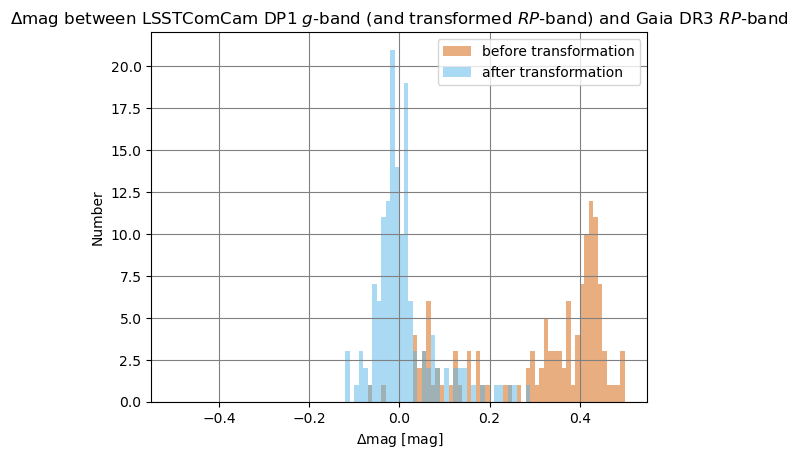

In [27]:
dmag_orig = matches_dp1_gaiadr3.loc[:,'dmag_g_cc_BP_gaia']
dmag_new  = matches_dp1_gaiadr3.loc[:,'dmag_BP_poly']
mag_g_cc = matches_dp1_gaiadr3['g_psfMag']

dmag_min = -0.5
dmag_max = 0.5

if len(dmag_new) < 100:
    plt.hist(dmag_orig, bins=10, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=10, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
else:
    plt.hist(dmag_orig, bins=100, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=100, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after transformation')
plt.xlabel('$\\Delta$mag [mag]')
plt.ylabel('Number')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band")

Create a scatter plot of the $\Delta$mags (both before transformation and post transformation) vs. color.  Note that the Gaia DR3 $RP$-band differs substantially from the LSSTCamCom DP1 $i$-band; so the transformation is fairly large.

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band vs. color')

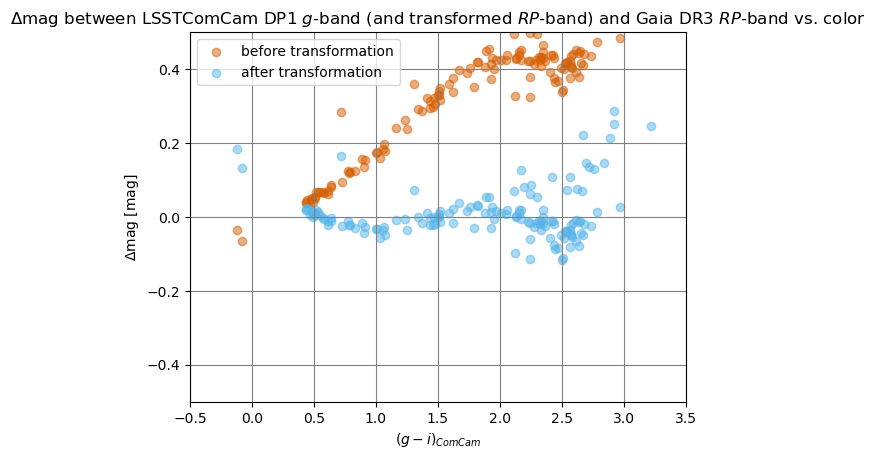

In [28]:
color = matches_dp1_gaiadr3.loc[:,'gi_psfMag']

dmag_min = -0.5
dmag_max = 0.5
color_min = -0.5
color_max = 3.5

plt.scatter(color, dmag_orig, color=colors[2], alpha=0.50, label='before transformation')
plt.scatter(color, dmag_new, color=colors[5], alpha=0.50, label='after transformation')
plt.axis([color_min, color_max, dmag_min, dmag_max])
plt.xlabel('$(g-i)_{ComCam}$')
plt.ylabel('$\\Delta$mag [mag]')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band vs. color")

## 6. Lookup table transformation:  LSSTComCam $g$ --> Gaia DR3 $BP_{gaia}$

Next, look at the lookup table transformation from DP1 $g$-band to Gaia DR3 $BP$-band.  

### 6.1 Examine the transformation relation

Find the section in <a href="https://rtn-099.lsst.io/">RTN-099</a> that describes the lookup table relation between the DP1 system and the Gaia DR3 system.

Here is the line from RTN-099 that describes the lookup table transformation from DP1 $g$-band to Gaia DR3 $BP$-band:

| Conversion | RMS | Applicable Color Range | QA Plot | Lookup Table |
|:-----------|----:|:-----------------------|:------- |:-------------|
| $g_{ComCam} \to BP_{gaia}$ | 0.013 | $0.3 < (g-i)_{ComCam} < 2.8$ | [link](_static/plots/qaPlot_transInterp.ComCam_to_GaiaDR3_ECDFS.BP_gaia_gi_ComCam.png) | [link](_static/data/transInterp.ComCam_to_GaiaDR3_ECDFS.BP_gaia_gi_ComCam.csv) |

Here are the quality‑assurance (QA) plots from <a href="https://rtn-099.lsst.io/">RTN-099</a> that document the lookup‑table transformation from the DP1 $g$‑band to the Gaia DR3 $RP$‑band. The lookup table is constructed by binning matched stars in the ECDFS field by their Rubin DP1 $(g–i)$ color, and then tabulating the median magnitude offset between the Gaia DR3 RP‑band and the Rubin DP1 g‑band for the stars in each color bin.

![Comparison of LSSTComCam DP1 g-band and Gaia DR3 BP-band photometry](https://rtn-099.lsst.io/_downloads/9807759cfea52cf26a8d0fa8a8474e45/qaPlot_transInterp.ComCam_to_GaiaDR3_ECDFS.BP_gaia_gi_ComCam.png)

*Figure 4: Comparison of LSSTComCam g-band and Gaia DR3 BP-band photometry.  (top left) The RMS of the linearly interpolated lookup table relation and the applicable color range. (top right) The difference in magnitudes vs. color before any transformation. (bottom left) 1d histogram of the residuals from the interpolated lookup table relation. (bottom right) residuals of the interpolated lookup table relation vs. color.*


### 6.2  Apply the transformation

Copy the URL of the lookup table link from the RTN-099 line in Section 6.1 and assign it to the variable `lut_url`:

In [29]:
lut_url = "https://rtn-099.lsst.io/_downloads/54cfc025a795e6ca410bd9dde0f11dda/transInterp.ComCam_to_GaiaDR3_ECDFS.BP_gaia_gi_ComCam.csv"

Read the lookup table over the network into a pandas dataframe, `df_lut` and then display its contents.

In [30]:
df_lut = pd.read_csv(lut_url)

display(df_lut)


,bin_label,bin_interval,bin_num,bin_mean,bin_stddev,bin_stderr,bin_median,bin_rstddev,bin_unc
0,0.35,"(0.3, 0.4]",13,-0.031628,0.013325,0.003847,-0.032934,0.007477,0.002599
1,0.45,"(0.4, 0.5]",32,-0.049921,0.012825,0.002303,-0.049748,0.010894,0.002414
2,0.55,"(0.5, 0.6]",36,-0.065647,0.009385,0.001586,-0.066948,0.009199,0.001922
3,0.65,"(0.6, 0.7]",23,-0.082396,0.010904,0.002325,-0.085100,0.010291,0.002689
4,0.75,"(0.7, 0.8]",23,-0.104497,0.047338,0.010092,-0.113668,0.015097,0.003945
5,0.85,"(0.8, 0.9]",15,-0.136744,0.017537,0.004687,-0.132753,0.007937,0.002569
6,0.95,"(0.9, 1.0]",20,-0.158882,0.018708,0.004292,-0.157347,0.014995,0.004202
7,1.05,"(1.0, 1.1]",24,-0.189826,0.018843,0.003929,-0.183414,0.019646,0.005026
8,1.15,"(1.1, 1.2]",13,-0.220930,0.015722,0.004538,-0.224068,0.013401,0.004658
9,1.25,"(1.2, 1.3]",16,-0.250503,0.025536,0.006593,-0.251977,0.019101,0.005985


Create a 1-d linear interpolation of the median magnitude offset (`bin_median`) vs. the midpoint of the DP1 $(g-i)$-color bin (`bin_label`).

In [31]:
response = interpolate.interp1d(\
                  df_lut.bin_label.values.astype(float), \
                  df_lut.bin_median.values, \
                  bounds_error=False, fill_value=0., \
                  kind='linear')


Calculate and apply the offsets derived from the lookup table.  Display the results.

In [32]:
# Calculate and apply the LUT offset...

df_dp1['BP_gaia_lut_offset'] = response(df_dp1['gi_psfMag'].values)
df_dp1['BP_gaia_lut'] = df_dp1['g_psfMag'] + df_dp1['BP_gaia_lut_offset']

display(df_dp1)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,ri_psfMag,gi_psfMag,i_ps1_poly_offset,i_ps1_poly,i_des_poly_offset,i_des_poly,BP_gaia_poly_offset,BP_gaia_poly,BP_gaia_lut_offset,BP_gaia_lut
0,53.426710,-28.048048,611254316728079110,20.344200,18.753799,18.169399,17.973700,17.897800,0.003464,0.000244,...,0.195700,0.780100,-0.005079,17.968620,-0.016544,17.957155,-0.138972,18.614828,-0.119413,18.634386
1,53.448204,-28.037606,611254316728079756,25.531500,23.614901,22.276501,21.103300,20.583799,0.339714,0.008660,...,1.173201,2.511600,0.019162,21.122463,-0.149415,20.953884,-0.454750,23.160151,-0.417328,23.197572
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,1.058001,2.347401,0.016864,15.796063,-0.129383,15.649817,-0.445649,17.680950,-0.436720,17.689880
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,0.112600,0.505001,-0.008930,16.221069,-0.004715,16.225285,-0.044088,16.690912,-0.059208,16.675792
4,53.414971,-28.053233,611254316728078899,26.046600,23.978100,22.803400,22.283100,22.035400,0.492280,0.011412,...,0.520300,1.695000,0.007730,22.290831,-0.055885,22.227215,-0.366340,23.611759,-0.386252,23.591848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,53.364575,-27.988567,611255003922838370,NaN,23.570101,22.291000,21.682800,21.408001,NaN,0.007885,...,0.608200,1.887300,0.010422,21.693222,-0.073251,21.609550,-0.396884,23.173218,-0.421813,23.148287
975,53.291419,-27.993240,611255003922838300,24.216999,21.688900,20.392900,19.286600,18.794201,0.099074,0.001507,...,1.106300,2.402300,0.017632,19.304232,-0.136081,19.150520,-0.449178,21.239721,-0.417723,21.271177
976,53.157799,-27.852838,611255759837080880,NaN,24.310301,22.947599,22.084101,21.698500,NaN,0.015467,...,0.863499,2.226200,0.015167,22.099268,-0.114596,21.969503,-0.436131,23.874170,-0.437000,23.873301
977,53.185716,-27.850345,611255759837080928,19.718901,18.725201,18.247601,18.044701,17.952400,0.002357,0.000234,...,0.202900,0.680500,-0.006473,18.038227,-0.012262,18.032438,-0.106035,18.619165,-0.093814,18.631387


### 6.3  Test the transformation

Test the transformation by comparing the Gaia DR3 $RP$-band magnitudes estimated from the DP1 data in ECDFS against the Gaia DR3 $RP$-band magnitudes from the Gaia DR3 data themselves in ECDFS.

#### 6.3.1  Grab ECDFS data from Gaia DR3

This was already done in Section 5.3.1.  No need to do it again.

#### 6.3.2  Match the ECDFS data from LSSTComCam with the ECDFS data from Gaia DR3

We will re-do this, as `df_dp1` has additional information now.

In [33]:
matches_dp1_gaiadr3, unmatched_dp1_gaiadr3 = cross_match_catalogs(df_dp1, df_gaiadr3, 'coord_ra', 'coord_dec', 'ra', 'dec')
display(matches_dp1_gaiadr3)

,coord_ra,coord_dec,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,u_psfMagErr,g_psfMagErr,...,match_pmra_error,match_pmdec,match_pmdec_error,match_phot_g_mean_mag,match_phot_g_mean_mag_error,match_phot_bp_mean_mag,match_phot_bp_mean_mag_error,match_phot_rp_mean_mag,match_phot_rp_mean_mag_error,match_bp_rp
2,53.451077,-28.040253,611254316728079755,20.675301,18.126600,16.837200,15.779200,15.337100,0.004685,0.000182,...,0.029912,-9.296183,0.043137,16.451174,0.000375,17.696598,0.006460,15.348310,0.001445,2.348289
3,53.463196,-28.035149,611254316728079531,17.867901,16.735001,16.342600,16.230000,16.196600,0.000819,0.000100,...,0.028813,2.968138,0.040988,16.357779,0.000312,16.680897,0.002528,15.873368,0.001770,0.807528
11,53.440408,-27.981976,611255003922837625,22.448000,20.000401,18.708500,17.700800,17.259100,0.021920,0.000497,...,0.094520,-14.860081,0.138640,18.359459,0.000991,19.504538,0.029346,17.296259,0.006758,2.208279
18,53.456495,-28.020062,611255003922836342,23.278400,20.860201,19.575399,18.126900,17.492701,0.046179,0.000907,...,0.119693,-59.558893,0.174562,18.879253,0.001372,20.424517,0.055852,17.679106,0.008471,2.745411
19,53.429906,-28.007648,611255003922837165,24.596701,21.953899,20.604900,19.112400,18.443501,0.155153,0.001970,...,0.251104,7.538019,0.396894,19.875956,0.002630,21.346970,0.083771,18.663813,0.021679,2.683157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,53.316166,-27.945378,611255003922842181,24.063200,21.475300,20.112200,18.806999,18.243401,0.093358,0.001295,...,0.193302,1.794308,0.278937,19.556559,0.001888,20.795033,0.062489,18.366001,0.016274,2.429031
949,53.316484,-27.944627,611255003922842182,26.105301,23.063000,21.756901,20.207701,19.528099,0.625584,0.004870,...,0.193302,1.794308,0.278937,19.556559,0.001888,20.795033,0.062489,18.366001,0.016274,2.429031
950,53.326705,-27.936112,611255003922842180,21.557899,19.042900,17.763100,16.885700,16.507200,0.010115,0.000272,...,0.054255,2.575072,0.082315,17.527222,0.000580,18.595356,0.011217,16.496214,0.003022,2.099142
951,53.324495,-27.951618,611255003922841835,23.855000,21.260900,19.886299,18.289000,17.571600,0.072636,0.001096,...,0.136242,7.211520,0.194936,19.048449,0.001447,20.777252,0.063919,17.810259,0.007013,2.966993


#### 6.3.3  Compare the LSSTComCam-estimated BP_gaia magnitudes with the Gaia DR3 BP_gaia magnitudes

Calculate differences between DP1-estimated Gaia DR3 $RP$-band magnitude from the lookup table method and the actual Gaia DR3 $RP$-band magnitude ("after transformation"):We re-do this, since there is new info from the lookup table method.

In [34]:
matches_dp1_gaiadr3['dmag_BP_lut'] = matches_dp1_gaiadr3['BP_gaia_lut'] - matches_dp1_gaiadr3['match_phot_bp_mean_mag']

Plot the histogram of the $\Delta$mags for before transformation, for after the polynomial-based transformation, and for after the lookup-table-based transformation.

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band')

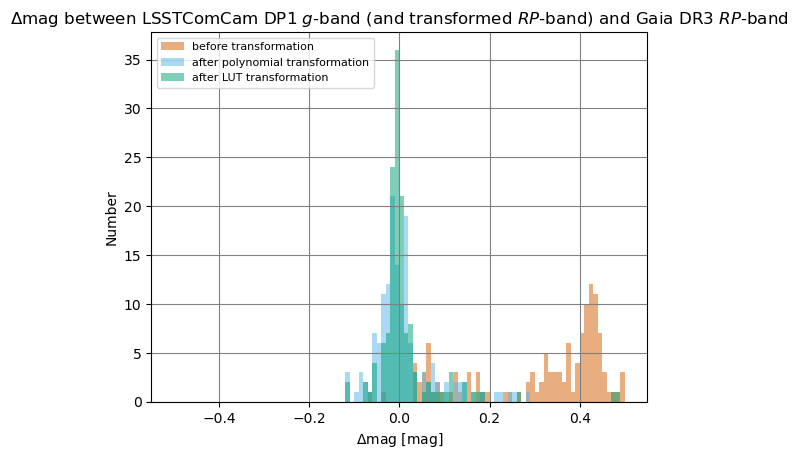

In [35]:
dmag_new_lut  = matches_dp1_gaiadr3.loc[:,'dmag_BP_lut']

dmag_min = -0.5
dmag_max = 0.5

if len(dmag_new) < 100:
    plt.hist(dmag_orig, bins=10, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=10, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after polynomial transformation')
    plt.hist(dmag_new_lut, bins=10, range=(dmag_min, dmag_max), color=colors[1], alpha=0.50, label='after LUT transformation')
else:
    plt.hist(dmag_orig, bins=100, range=(dmag_min, dmag_max), color=colors[2], alpha=0.50, label='before transformation')
    plt.hist(dmag_new, bins=100, range=(dmag_min, dmag_max), color=colors[5], alpha=0.50, label='after polynomial transformation')
    plt.hist(dmag_new_lut, bins=100, range=(dmag_min, dmag_max), color=colors[1], alpha=0.50, label='after LUT transformation')
plt.xlabel('$\\Delta$mag [mag]')
plt.ylabel('Number')
plt.grid(True)
plt.grid(color='grey')
plt.legend(loc='upper left', fontsize=8)
plt.title(r"$\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band")

Create a scatter plot of the $\Delta$mags vs. color for before transformation, for after the polynomial-based transformation, and for after the lookup-table-based transformation.  Note the small systematic trends vs. color seen in the the polynomial-based transformation are effectively eliminated by the lookup-table-based transformation.

Text(0.5, 1.0, '$\\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band vs. color')

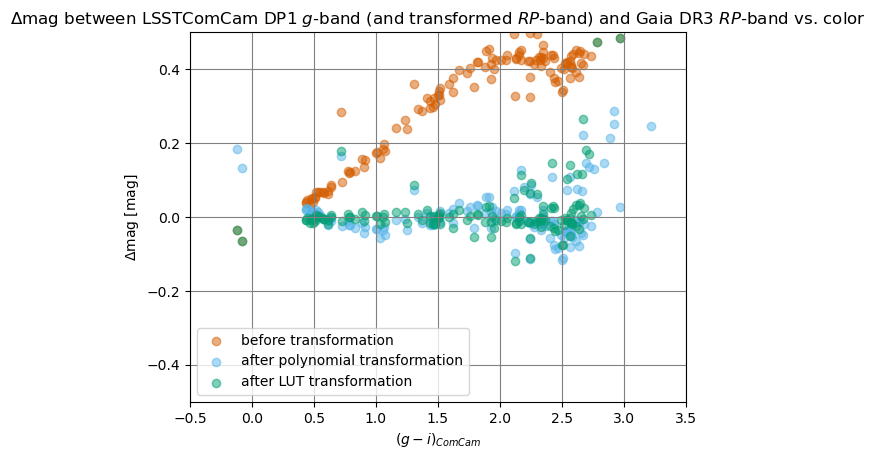

In [36]:
dmag_min = -0.5
dmag_max = 0.5
color_min = -0.5
color_max = 3.5

plt.scatter(color, dmag_orig, color=colors[2], alpha=0.50, label='before transformation')
plt.scatter(color, dmag_new, color=colors[5], alpha=0.50, label='after polynomial transformation')
plt.scatter(color, dmag_new_lut, color=colors[1], alpha=0.50, label='after LUT transformation')
plt.axis([color_min, color_max, dmag_min, dmag_max])
plt.xlabel('$(g-i)_{ComCam}$')
plt.ylabel('$\\Delta$mag [mag]')
plt.grid(True)
plt.grid(color='grey')
plt.legend()
plt.title(r"$\Delta$mag between LSSTComCam DP1 $g$-band (and transformed $RP$-band) and Gaia DR3 $RP$-band vs. color")

## 7. Sandbox


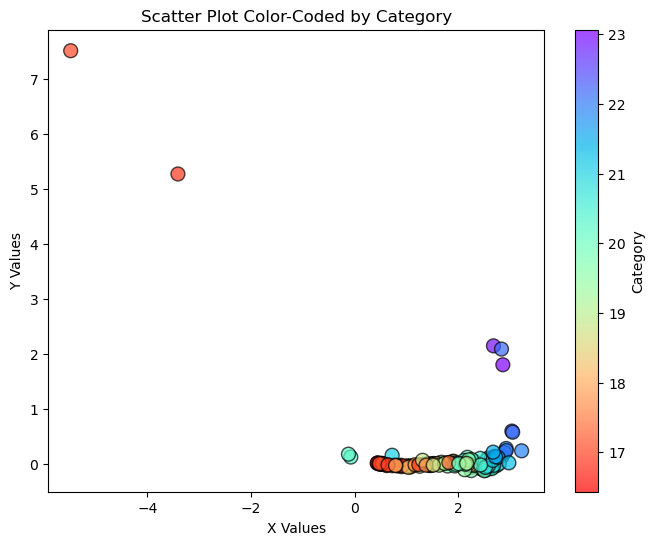

In [37]:
#dmag_orig = matches_dp1_gaiadr3.loc[:,'dmag_g_cc_BP_gaia']
#dmag_new  = matches_dp1_gaiadr3.loc[:,'dmag_BP_poly']
mag_g_cc = matches_dp1_gaiadr3['g_psfMag']


# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x=color,
    y=dmag_new,
    c=mag_g_cc, # Color by the 'category' column
    cmap='rainbow_r',    # Optional: Choose a colormap (e.g., 'plasma', 'coolwarm')
    s=100,             # Optional: Adjust symbol size
    alpha=0.7,         # Optional: Adjust transparency
    edgecolor='k'      # Optional: Add a black edge to markers
)

# Add a color bar to explain the colors
plt.colorbar(scatter, label='Category')

# Add titles and labels
plt.title('Scatter Plot Color-Coded by Category')
plt.xlabel('X Values')
plt.ylabel('Y Values')

# Display the plot
plt.show()
